# NCAR Innovator Program Project

### Notebook by: Maria J. Molina (NCAR/University of Maryland) and Jessica Moulite (Howard University)

Import packages

In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from shapely.geometry import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
def cel_to_far(tmp):
    """
    Convert celsius to farenheit
    """
    newtmp = []
    for i in tmp:
        if i == 99.9:
            newtmp.append(np.nan)
        if i != 99.9:
            newtmp.append((i * (9/5)) + 32)
    return np.array(newtmp)


def cel_to_nan(tmp):
    """
    Change 9999 to np.nan
    """
    newtmp = []
    for i in tmp:
        if i == 99.9:
            newtmp.append(np.nan)
        if i != 99.9:
            newtmp.append(i)
    return np.array(newtmp)


def convert_to_datetime(time_value):
    """
    Convert to a datetime object to be able to compute time difference.
    """
    return datetime.datetime(
        pd.to_datetime(time_value).year,
        pd.to_datetime(time_value).month,
        pd.to_datetime(time_value).day,
        pd.to_datetime(time_value).hour,
        pd.to_datetime(time_value).minute,
        pd.to_datetime(time_value).second,
    )


def compute_time_difference(a, b):
    """
    Compute time difference between two times.
    """
    if a >= b:
        return convert_to_datetime(a) - convert_to_datetime(b)
    if b > a:
        return convert_to_datetime(b) - convert_to_datetime(a)


def extract_era5_time(t_daily, t_full):
    """
    Extract the era5 temperature corresponding time.
    """
    era5_time_array = []

    for i, j in zip(t_daily.time, t_daily):

        tmp = t_full.sel(
            time=slice(i, pd.to_datetime(i.values) + datetime.timedelta(hours=23)))

        era5_time_array.append(tmp.where(tmp == j, drop=True).time.values)

    return era5_time_array


def ends(df, x=5):
    """
    Viewing the beginnings and ends.
    """
    return pd.concat([df.head(x),df.tail(x)])

### load in our csv file with temperatures from Shading Dade

In [3]:
Shading_dade_temp = pd.read_csv('/glade/scratch/molina/ShadingDade_NOAA_KMIA_Temperature.csv')

In [4]:
Shading_dade_temp.columns

Index(['Datetime', 'ShadingDade_Temperature_Daily_Max (C)',
       'ShadingDade_Temperature_Daily_Min (C)',
       'NOAA_KMIA_Temperature_Daily_Max (C)',
       'NOAA_KMIA_Temperature_Daily_Min (C)',
       'ShadingDade_Temperature_Daily_Max (F)',
       'ShadingDade_Temperature_Daily_Min (F)',
       'NOAA_KMIA_Temperature_Daily_Max (F)',
       'NOAA_KMIA_Temperature_Daily_Min (F)',
       'Daily_Temperature_Max_Difference (C)',
       'Daily_Temperature_Min_Difference (C)',
       'Daily_Temperature_Max_Difference (F)',
       'Daily_Temperature_Min_Difference (F)',
       'Corresponding_Datetime_ShadingDade_DailyMax',
       'Corresponding_Datetime_ShadingDade_DailyMin',
       'Corresponding_Datetime_NOAA_KMIA_DailyMax',
       'Corresponding_Datetime_NOAA_KMIA_DailyMin',
       'Corresponding_Datetime_NOAA_KMIA_DailyMax_Difference (C)',
       'Corresponding_Datetime_NOAA_KMIA_DailyMax_Difference (F)',
       'Corresponding_Datetime_NOAA_KMIA_DailyMin_Difference (C)',
       'Cor

In [5]:
# location of little haiti temperature sensor
SD_latitude  = 25.8436392
SD_longitude = -80.1816499 % 360

In [6]:
alltmaxtimes = pd.to_datetime(
    Shading_dade_temp['Corresponding_Datetime_ShadingDade_DailyMax'].values)

In [7]:
alltmintimes = pd.to_datetime(
    Shading_dade_temp['Corresponding_Datetime_ShadingDade_DailyMin'].values)

In [8]:
ends(Shading_dade_temp, 2)

,Datetime,ShadingDade_Temperature_Daily_Max (C),ShadingDade_Temperature_Daily_Min (C),NOAA_KMIA_Temperature_Daily_Max (C),NOAA_KMIA_Temperature_Daily_Min (C),ShadingDade_Temperature_Daily_Max (F),ShadingDade_Temperature_Daily_Min (F),NOAA_KMIA_Temperature_Daily_Max (F),NOAA_KMIA_Temperature_Daily_Min (F),Daily_Temperature_Max_Difference (C),...,NOAA_Corresponding_Temperature_During_ShadingDade_DailyMax (C),NOAA_Corresponding_Temperature_During_ShadingDade_DailyMin (C),ShadingDade_Corresponding_Temperature_During_NOAA_DailyMax (C),ShadingDade_Corresponding_Temperature_During_NOAA_DailyMin (C),NOAA_Corresponding_Temperature_During_ShadingDade_DailyMax (F),NOAA_Corresponding_Temperature_During_ShadingDade_DailyMin (F),ShadingDade_Corresponding_Temperature_During_NOAA_DailyMax (F),ShadingDade_Corresponding_Temperature_During_NOAA_DailyMin (F),Absolute_time_difference_tmax_NOAA_ShadingDade (day H:M:S),Absolute_time_difference_tmin_NOAA_ShadingDade (day H:M:S)
0,2019-06-09,33.75,25.125,31.1,25.0,92.75,77.225,87.98,77.00,-2.65,...,27.8,27.2,25.625,28.250,82.04,80.96,78.125,82.850,0 days 03:53:00,0 days 02:29:00
1,2019-06-10,38.50,23.250,31.7,23.9,101.30,73.850,89.06,75.02,-6.80,...,25.6,26.7,27.375,25.250,78.08,80.06,81.275,77.450,0 days 03:53:00,0 days 04:36:00
82,2019-08-30,35.00,23.875,32.2,25.0,95.00,74.975,89.96,77.00,-2.80,...,27.2,26.7,29.750,30.250,80.96,80.06,85.550,86.450,0 days 05:53:01,0 days 03:02:01
83,2019-08-31,36.50,26.750,32.2,26.7,97.70,80.150,89.96,80.06,-4.30,...,30.0,27.8,31.625,33.625,86.00,82.04,88.925,92.525,0 days 03:53:00,0 days 01:53:01


### ERA5 work

Download source for ERA5: https://rda.ucar.edu/datasets/ds633.0/

ERA5 (ECMWF -- European Centre for Medium-Range Weather Forecasts -- fifth reanalysis) reference: https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.3803

In [9]:
# open files
ds_ = xr.open_mfdataset(
    '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/*/e5.oper.an.sfc.128_235_skt.ll025sc.*.nc'
)['SKT']

# time slice
ds_ = ds_.sel(time=slice('2019-06-09T00:00:00', '2019-08-31T23:00:00'))

In [10]:
ds_

<xarray.DataArray 'SKT' (time: 2016, latitude: 721, longitude: 1440)>
dask.array<getitem, shape=(2016, 721, 1440), dtype=float32, chunksize=(744, 721, 1440)>
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2019-06-09 ... 2019-08-31T23:00:00
Attributes:
    long_name:                                          Skin temperature
    short_name:                                         skt
    units:                                              K
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    235
    minimum_value:                                      207.77914
    maximum_value:                                      347.40265
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7

/glade/work/molina/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


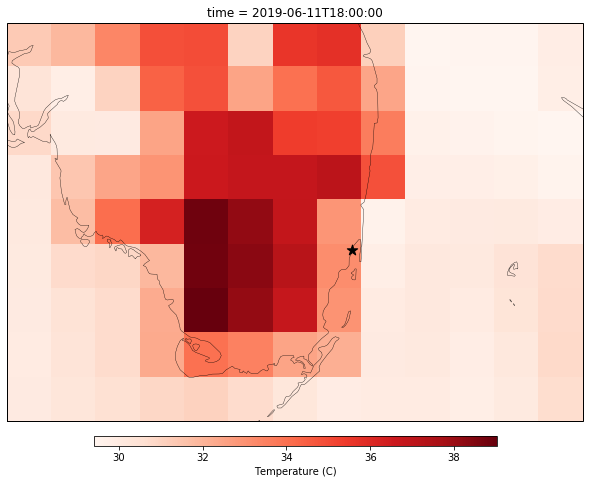

In [11]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

pc = (ds_.isel(time=66)-273).sel(
    latitude=slice(27,25), 
    longitude=slice(278,281)).plot.pcolormesh(
    cmap='Reds', ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())

# colorbar 
cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label('Temperature (C)')

ax.scatter(SD_longitude, SD_latitude, s=120, marker='*', color='k', transform=ccrs.PlateCarree())

# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=100)

ax.margins(x=0,y=0)

plt.tight_layout()

plt.savefig('/glade/scratch/molina/ERA5_skt_demo.png', dpi=500)
plt.show()

### ERA5 temperature during the Shading Dade daily maximum (2019)

In [12]:
era5_temp_corresponding_sdmax = ds_.sel(longitude = SD_longitude, 
                                        latitude = SD_latitude, 
                                        time = alltmaxtimes, method='nearest') - 273.15

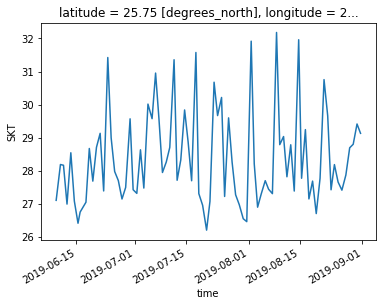

In [13]:
era5_temp_corresponding_sdmax.plot()

### differences (temperature)

In [14]:
# difference between shading dade temperature maximum and the era5 corresponding temperature at that time (C)
tmax_daily_difference_C = Shading_dade_temp[
    'ShadingDade_Temperature_Daily_Max (C)'] - era5_temp_corresponding_sdmax.values

In [15]:
tmax_daily_difference_C.isnull().sum()

0

In [16]:
# difference between shading dade temperature maximum and the era5 corresponding temperature at that time (F)
tmax_daily_difference_F = Shading_dade_temp[
    'ShadingDade_Temperature_Daily_Max (F)'] - cel_to_far(
    era5_temp_corresponding_sdmax.values)

### ERA5 temperature during the Shading Dade daily minimum (2019)

In [17]:
era5_temp_corresponding_sdmin = ds_.sel(longitude=SD_longitude, 
                                        latitude=SD_latitude, 
                                        time=alltmintimes, method='nearest') - 273.15

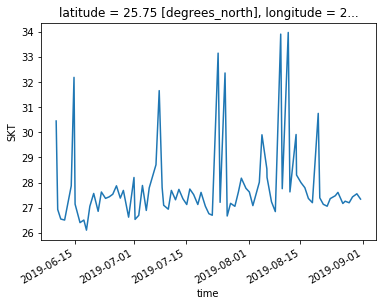

In [18]:
era5_temp_corresponding_sdmin.plot()

In [19]:
# difference between shading dade temperature minimum and the era5 corresponding temperature at that time (C)
tmin_daily_difference_C = Shading_dade_temp[
    'ShadingDade_Temperature_Daily_Min (C)'] - era5_temp_corresponding_sdmin.values

In [20]:
tmin_daily_difference_C.isnull().sum()

0

In [21]:
# difference between shading dade temperature minimum and the era5 corresponding temperature at that time (F)
tmin_daily_difference_F = Shading_dade_temp[
    'ShadingDade_Temperature_Daily_Min (F)'] - cel_to_far(
    era5_temp_corresponding_sdmin.values)

### ERA5 daily temperature maximum (2019)

In [22]:
era5_temp = ds_.sel(longitude=SD_longitude, 
                    latitude=SD_latitude, method='nearest') - 273.15

In [23]:
era5_tmax = era5_temp.resample(time='D').max()

### ERA5 daily temperature minimum (2019)

In [24]:
era5_tmin = era5_temp.resample(time='D').min()

### ERA5 daily temperature maximum time (2019)

In [25]:
era5_tmax_time = extract_era5_time(era5_tmax, era5_temp)

In [26]:
era5_tmax_all_time = pd.to_datetime(np.array(era5_tmax_time))

In [27]:
# absolute time difference between daily maximum temperature (ERA5 and Shading Dade)
tmax_diff = []
for i, j in zip(
    pd.to_datetime(Shading_dade_temp['Corresponding_Datetime_ShadingDade_DailyMax']), era5_tmax_time):
    tmax_diff.append(compute_time_difference(i, j[0]))
tmax_diff = np.array(tmax_diff)

### ERA5 daily temperature minimum time (2019)

In [28]:
era5_tmin_time = extract_era5_time(era5_tmin, era5_temp)

In [29]:
era5_tmin_all_time = pd.to_datetime(np.array(era5_tmin_time))

In [30]:
# absolute time difference between daily minimum temperature (ERA5 and Shading Dade)
tmin_diff = []
for i, j in zip(
    pd.to_datetime(Shading_dade_temp['Corresponding_Datetime_ShadingDade_DailyMin']), era5_tmin_time):
    tmin_diff.append(compute_time_difference(i, j[0]))
tmin_diff = np.array(tmin_diff)

### create single csv file

In [31]:
data = {
    
'ShadingDade_Temperature_Daily_Max (C)' : Shading_dade_temp['ShadingDade_Temperature_Daily_Max (C)'],
'ShadingDade_Temperature_Daily_Max (F)' : Shading_dade_temp['ShadingDade_Temperature_Daily_Max (F)'],
    
'ShadingDade_Temperature_Daily_Min (C)' : Shading_dade_temp['ShadingDade_Temperature_Daily_Min (C)'],
'ShadingDade_Temperature_Daily_Min (F)' : Shading_dade_temp['ShadingDade_Temperature_Daily_Min (F)'],
    
'ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Max (C)': era5_temp_corresponding_sdmax.values,
'ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Max (F)': cel_to_far(era5_temp_corresponding_sdmax.values),
    
'ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Min (C)': era5_temp_corresponding_sdmin.values,
'ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Min (F)': cel_to_far(era5_temp_corresponding_sdmin.values),

'Daily_Temperature_Max_Difference (C)': tmax_daily_difference_C.values,
'Daily_Temperature_Max_Difference (F)': tmax_daily_difference_F.values,
    
'Daily_Temperature_Min_Difference (C)': tmin_daily_difference_C.values,
'Daily_Temperature_Min_Difference (F)': tmin_daily_difference_F.values,
    
'ERA5_Temperature_Daily_Max (C)': era5_tmax.values,
'ERA5_Temperature_Daily_Max (F)': cel_to_far(era5_tmax.values),
'ERA5_Temperature_Daily_Max_Datetime': era5_tmax_time,
    
'ERA5_Temperature_Daily_Min (C)': era5_tmin.values,
'ERA5_Temperature_Daily_Min (F)': cel_to_far(era5_tmin.values),
'ERA5_Temperature_Daily_Min_Datetime': era5_tmin_time,
    
'Absolute_time_difference_tmax_ERA5_ShadingDade (day H:M:S)': tmax_diff,
'Absolute_time_difference_tmin_ERA5_ShadingDade (day H:M:S)': tmin_diff,

       }

In [32]:
df_FINAL = pd.DataFrame(data)

In [33]:
df_FINAL

,ShadingDade_Temperature_Daily_Max (C),ShadingDade_Temperature_Daily_Max (F),ShadingDade_Temperature_Daily_Min (C),ShadingDade_Temperature_Daily_Min (F),ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Max (C),ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Max (F),ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Min (C),ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Min (F),Daily_Temperature_Max_Difference (C),Daily_Temperature_Max_Difference (F),Daily_Temperature_Min_Difference (C),Daily_Temperature_Min_Difference (F),ERA5_Temperature_Daily_Max (C),ERA5_Temperature_Daily_Max (F),ERA5_Temperature_Daily_Max_Datetime,ERA5_Temperature_Daily_Min (C),ERA5_Temperature_Daily_Min (F),ERA5_Temperature_Daily_Min_Datetime,Absolute_time_difference_tmax_ERA5_ShadingDade (day H:M:S),Absolute_time_difference_tmin_ERA5_ShadingDade (day H:M:S)
0,33.750,92.750,25.125,77.225,27.097412,80.775342,30.447235,86.805023,6.652588,11.974658,-5.322235,-9.580023,30.793427,87.428168,[2019-06-09T19:00:00.000000000],26.299408,79.338934,[2019-06-09T14:00:00.000000000],0 days 07:00:00,0 days 07:00:00
1,38.500,101.300,23.250,73.850,28.182709,82.728876,26.929047,80.472284,10.317291,18.571124,-3.679047,-6.622284,31.082977,87.949359,[2019-06-10T21:00:00.000000000],26.211578,79.180841,[2019-06-10T10:00:00.000000000],0 days 05:00:00,0 days 03:00:00
2,40.750,105.350,24.250,75.650,28.159943,82.687897,26.548737,79.787726,12.590057,22.662103,-2.298737,-4.137726,33.140900,91.653619,[2019-06-11T17:00:00.000000000],25.961334,78.730402,[2019-06-11T07:00:00.000000000],0 days 05:00:00,0 days 04:00:00
3,40.250,104.450,24.875,76.775,26.983856,80.570941,26.509674,79.717413,13.266144,23.879059,-1.634674,-2.942413,33.437897,92.188214,[2019-06-12T17:00:00.000000000],26.121490,79.018683,[2019-06-12T09:00:00.000000000],0 days 06:00:01,0 days 05:00:00
4,41.000,105.800,25.125,77.225,28.538422,83.369159,27.867157,82.160883,12.461578,22.430841,-2.742157,-4.935883,32.831482,91.096667,[2019-06-13T17:00:00.000000000],26.179535,79.123163,[2019-06-13T09:00:00.000000000],0 days 05:00:00,0 days 13:59:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,42.250,108.050,25.000,77.000,27.865143,82.157257,27.258759,81.065765,14.384857,25.892743,-2.258759,-4.065765,33.831268,92.896283,[2019-08-27T19:00:00.000000000],27.022736,80.640924,[2019-08-27T11:00:00.000000000],0 days 06:00:00,0 days 07:00:00
80,40.750,105.350,24.625,76.325,28.689606,83.641290,27.196747,80.954144,12.060394,21.708710,-2.571747,-4.629144,32.968475,91.343256,[2019-08-28T18:00:00.000000000],26.865631,80.358136,[2019-08-28T09:00:00.000000000],0 days 04:00:01,0 days 03:00:00
81,41.375,106.475,24.750,76.550,28.795929,83.832672,27.430176,81.374316,12.579071,22.642328,-2.680176,-4.824316,32.523224,90.541803,[2019-08-29T18:00:00.000000000],27.046600,80.683881,[2019-08-29T08:00:00.000000000],0 days 05:00:00,0 days 04:00:00
82,35.000,95.000,23.875,74.975,29.410400,84.938721,27.553497,81.596295,5.589600,10.061279,-3.678497,-6.621295,31.900299,89.420538,[2019-08-30T18:00:00.000000000],27.096283,80.773309,[2019-08-30T11:00:00.000000000],0 days 04:00:01,0 days 03:00:01


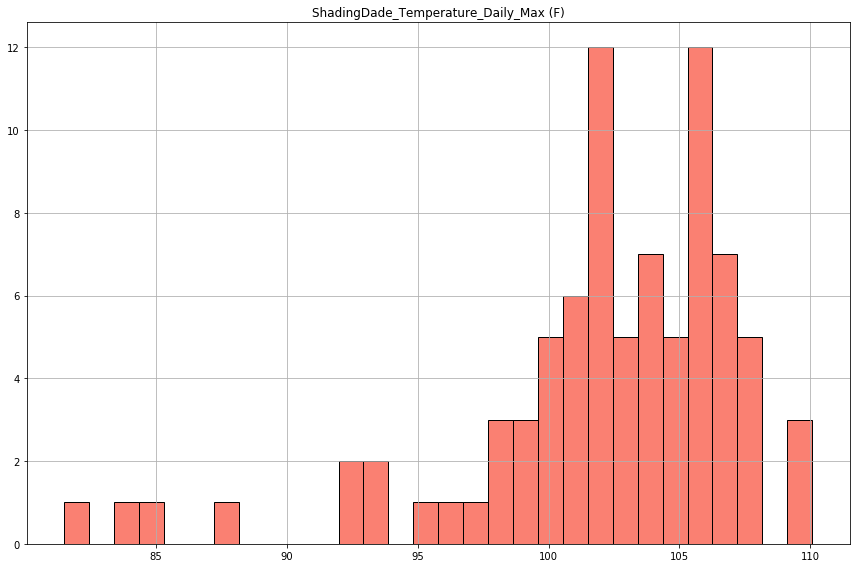

In [34]:
fig = df_FINAL.hist(
    'ShadingDade_Temperature_Daily_Max (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

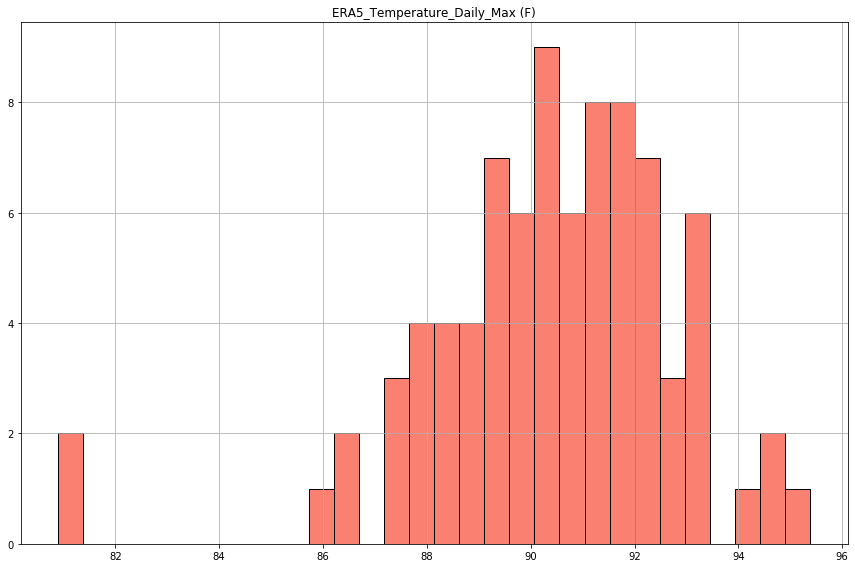

In [35]:
df_FINAL.hist('ERA5_Temperature_Daily_Max (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

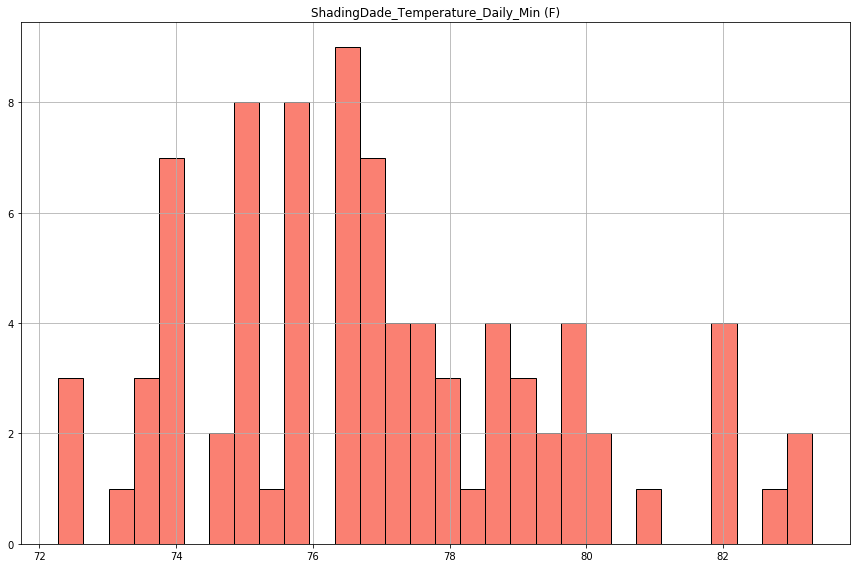

In [36]:
df_FINAL.hist('ShadingDade_Temperature_Daily_Min (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

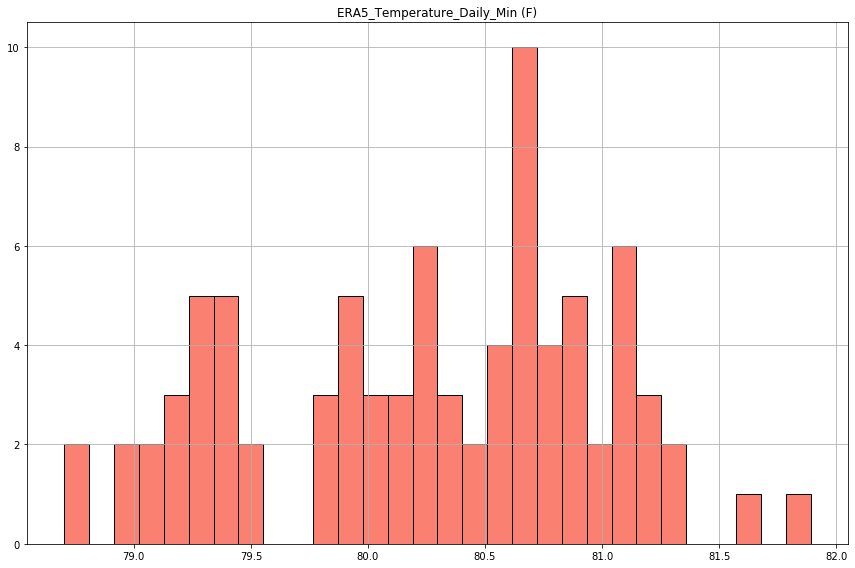

In [37]:
df_FINAL.hist('ERA5_Temperature_Daily_Min (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

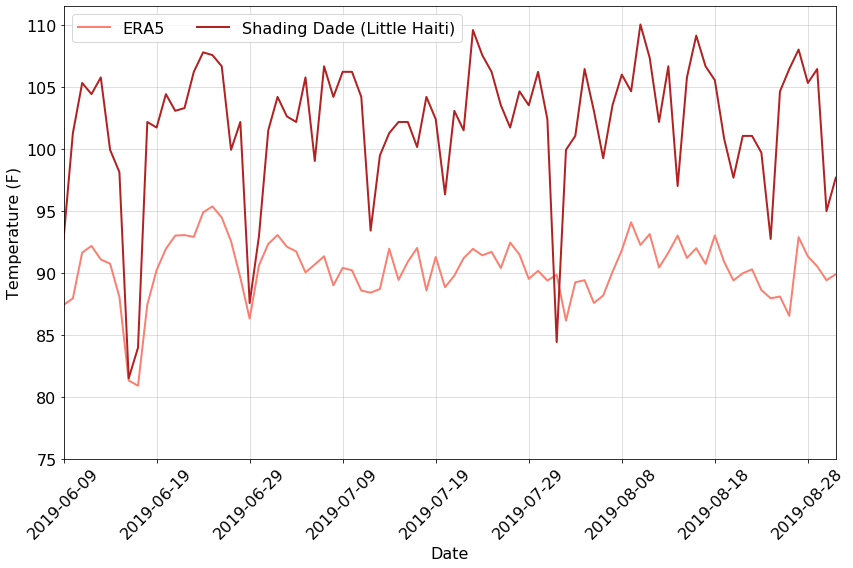

In [38]:
fig, ax = plt.subplots(figsize=(12,8))

ls0, = ax.plot(cel_to_far(era5_tmax.values), color='salmon', lw=2.0)
ls1, = ax.plot(Shading_dade_temp['ShadingDade_Temperature_Daily_Max (F)'].values, color='firebrick', lw=2.0)

ax.legend([ls0,ls1],['ERA5','Shading Dade (Little Haiti)'],
          fancybox=True, fontsize=16, ncol=2)

ax.set_xticks(np.arange(0,era5_temp_corresponding_sdmax.time.shape[0])[::10])
ax.set_xticklabels(pd.to_datetime(era5_temp_corresponding_sdmax.time).strftime('%Y-%m-%d').values[::10], 
                   rotation=45, fontsize=16)
ax.set_xlabel('Date', fontsize=16)

ax.set_yticks(np.arange(75,111,1)[::5])
ax.set_yticklabels(np.arange(75,111,1)[::5], fontsize=16)
ax.set_ylabel('Temperature (F)', fontsize=16)

ax.grid('--', alpha=0.5)
ax.margins(x=0)

plt.tight_layout()
plt.show()

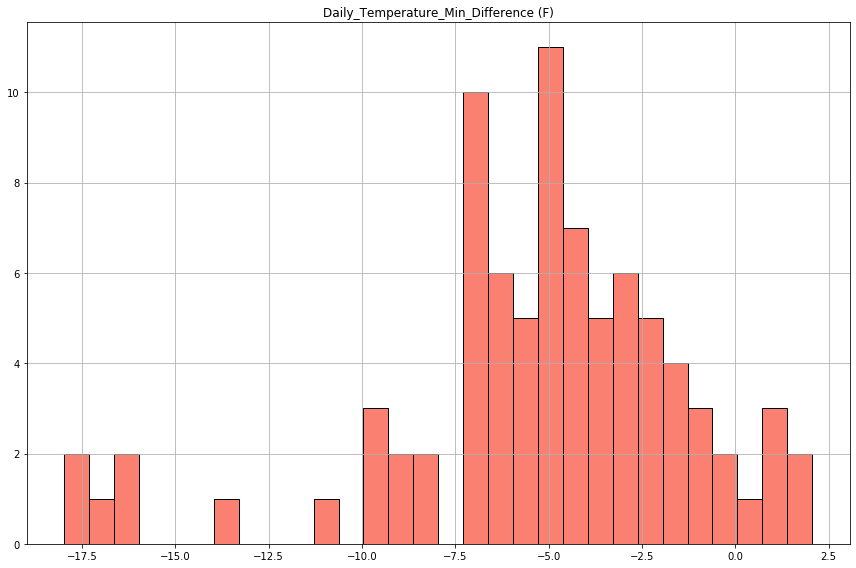

In [39]:
df_FINAL.hist('Daily_Temperature_Min_Difference (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

### save csv file

In [40]:
df_FINAL.isnull().sum()

ShadingDade_Temperature_Daily_Max (C)                              0
ShadingDade_Temperature_Daily_Max (F)                              0
ShadingDade_Temperature_Daily_Min (C)                              0
ShadingDade_Temperature_Daily_Min (F)                              0
ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Max (C)    0
ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Max (F)    0
ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Min (C)    0
ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Min (F)    0
Daily_Temperature_Max_Difference (C)                               0
Daily_Temperature_Max_Difference (F)                               0
Daily_Temperature_Min_Difference (C)                               0
Daily_Temperature_Min_Difference (F)                               0
ERA5_Temperature_Daily_Max (C)                                     0
ERA5_Temperature_Daily_Max (F)                                     0
ERA5_Temperature_Daily_Max_Datetim

In [41]:
df_FINAL.to_csv('/glade/scratch/molina/ShadingDade_ERA5_SkinTemperature.csv')